# Statistics for Data Science with Python
## Final assignment: Boston Housing Data Analysis

Bernadette Elliott-Bowman

_September 2025_

## Dataset Description

| Feature | Description |
|--------|-------------|
| `CRIM` | per capita crime rate by town |
| `ZN` | proportion of residential land zoned for lots over 25,000 sq.ft. |
| `INDUS` | proportion of non-retail business acres per town |
| `CHAS` | Charles River dummy variable (1 if tract bounds river; 0 otherwise) |
| `NOX` | nitric oxides concentration (parts per 10 million) |
| `RM` | average number of rooms per dwelling |
| `AGE` | proportion of owner-occupied units built prior to 1940 |
| `DIS` | weighted distances to five Boston employment centres |
| `RAD` | index of accessibility to radial highways |
| `TAX` | full-value property-tax rate per USD 10,000 |
| `PTRATIO` | pupil–teacher ratio by town |
| `LSTAT` | % lower status of the population |
| `MEDV` | Median value of owner-occupied homes in USD 1000's |

#### Import the required libraries we need for the lab.

In [33]:
import piplite
await piplite.install(['numpy', 'pandas'])
await piplite.install(['seaborn'])

In [34]:
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

#### Read the dataset in the csv file from the URL

In [35]:
from js import fetch
import io

URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ST0151EN-SkillsNetwork/labs/boston_housing.csv'
resp = await fetch(URL)
boston_url = io.BytesIO((await resp.arrayBuffer()).to_py())
boston_df=pd.read_csv(boston_url)

## Descriptive Statistics and Visualisations

#### Q1. Is there a significant difference in median value of houses bounded by the Charles river or not? (T-test for independent samples)¶
Provide a **bar plot** for the Charles river variable

**State the Hypothesis:**

H0: μ1 = μ2  → There is no difference in the median value of houses bounded by the Charles River

H1: μ1 ≠ μ2  → There is a difference in the median value of houses bounded by the Charles River

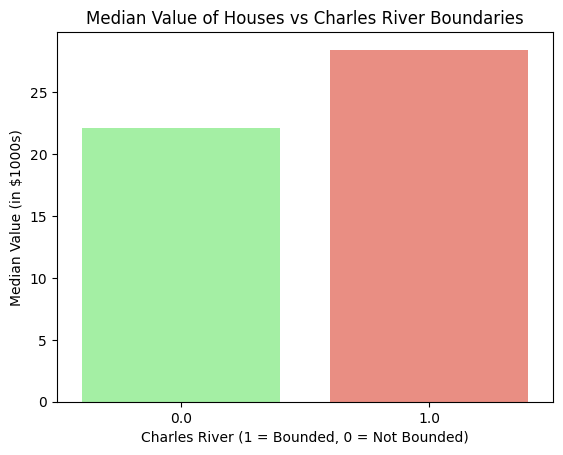

Levene’s Test statistic: 8.75190489604598
Levene’s Test p-value: 0.003238119367639829
Since p ≤ 0.05, we do NOT assume equal variances.


In [36]:
# Bar plot for CHAS variable
sns.barplot(x='CHAS', y='MEDV', data=boston_df, errorbar=None, hue='CHAS',palette=['palegreen', 'salmon'],legend=False)
plt.title('Median Value of Houses vs Charles River Boundaries')
plt.xlabel('Charles River (1 = Bounded, 0 = Not Bounded)')
plt.ylabel('Median Value (in $1000s)')
plt.show()

# Levene’s Test for equality of variances
levene_result = scipy.stats.levene(boston_df[boston_df['CHAS'] == 0]['MEDV'],
                                   boston_df[boston_df['CHAS'] == 1]['MEDV'],center='mean')

print("Levene’s Test statistic:", levene_result.statistic)
print("Levene’s Test p-value:", levene_result.pvalue)

if levene_result.pvalue > 0.05:
    print("Since p > 0.05, we assume equal variances.")
    equal_var = True
else:
    print("Since p ≤ 0.05, we do NOT assume equal variances.")
    equal_var = False


In [37]:
# Independent Samples T-test

t_stat, t_p_value = scipy.stats.ttest_ind(boston_df[boston_df['CHAS'] == 0]['MEDV'],
                      boston_df[boston_df['CHAS'] == 1]['MEDV'], equal_var=True)

print("T-test statistic:", t_stat)
print("T-test p-value:", t_p_value)

# --- Conclusion ---
alpha = 0.05
if t_p_value < alpha:
    print("Conclusion: p < 0.05 → Reject H0. There is a statistically significant difference in median value of houses bounded by the Charles river.")
else:
    print("Conclusion: p ≥ 0.05 → Fail to reject H0. No statistically significant difference found in median value of houses bounded by the Charles river.")


T-test statistic: -3.996437466090509
T-test p-value: 7.390623170519905e-05
Conclusion: p < 0.05 → Reject H0. There is a statistically significant difference in median value of houses bounded by the Charles river.


#### Q2. Is there a difference in Median values of houses (MEDV) for each proportion of owner occupied units built prior to 1940 (AGE)? (ANOVA)
For the "Median value of owner-occupied homes" provide a **boxplot.**

Provide a **boxplot** for the MEDV variable vs the AGE variable. (Discretize the age variable into three groups of 35 years and younger, between 35 and 70 years and 70 years and older)

In [38]:
boston_df.loc[(boston_df['AGE']<=35), 'age_group']='35 years and younger'
boston_df.loc[(boston_df['AGE']>35)&(boston_df['AGE']<70), 'age_group']='between 35 and 70 years'
boston_df.loc[(boston_df['AGE']>=70), 'age_group']='70 years and older'

**State the Hypothesis:**

H0: μ1 = μ2 = μ2 → There is no difference in Median values of houses (MEDV) across the age groups

H1: There is a difference in Median values of houses (MEDV) in at least one age group 

In [39]:
younger = boston_df[boston_df['age_group']=='35 years and younger']['MEDV']
middle = boston_df[boston_df['age_group']=='between 35 and 70 years']['MEDV']
older = boston_df[boston_df['age_group']=='70 years and older']['MEDV']

In [40]:
f_statistic, p_value = scipy.stats.f_oneway(younger, middle, older)
print("F_statistic: {0}, P-value: {1}".format(f_statistic,p_value))

F_statistic: 36.40764999196599, P-value: 1.7105011022702984e-15


**Conclusion:** p < 0.05 → Reject H0. There is a difference in Median values of houses (MEDV) in at least one age group.

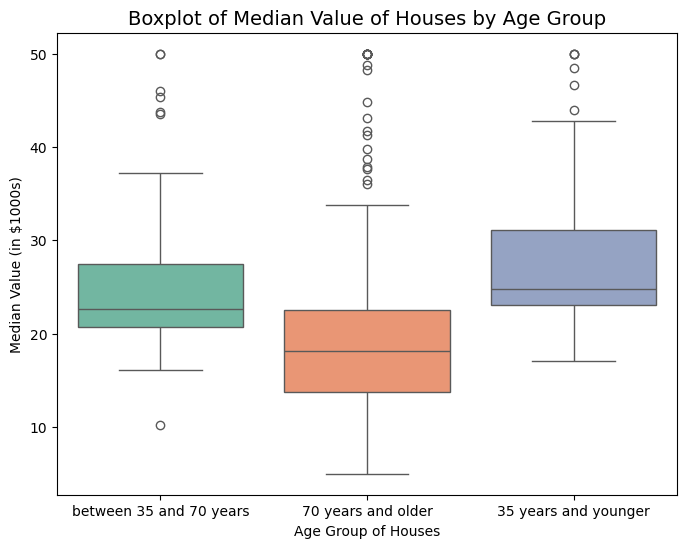

In [41]:
# Create boxplot for MEDV vs Age group
plt.figure(figsize=(8,6))
sns.boxplot(x='age_group', y='MEDV', data=boston_df, hue='age_group', palette="Set2", legend=False)

plt.title('Boxplot of Median Value of Houses by Age Group', fontsize=14)
plt.xlabel('Age Group of Houses')
plt.ylabel('Median Value (in $1000s)')
plt.show()

#### Q3. Can we conclude that there is no relationship between Nitric oxide concentrations and proportion of non-retail business acres per town? (Pearson Correlation)

Provide a **scatter plot** to show the relationship between Nitric oxide concentrations and the proportion of non-retail business acres per town. What can you say about the relationship?

**State the Hypothesis:**

H0: Nitric oxide concentration is not correlated with the proportion of non-retail business acres per town

H1: Nitric oxide concentration is correlated with the proportion of non-retail business acres per town

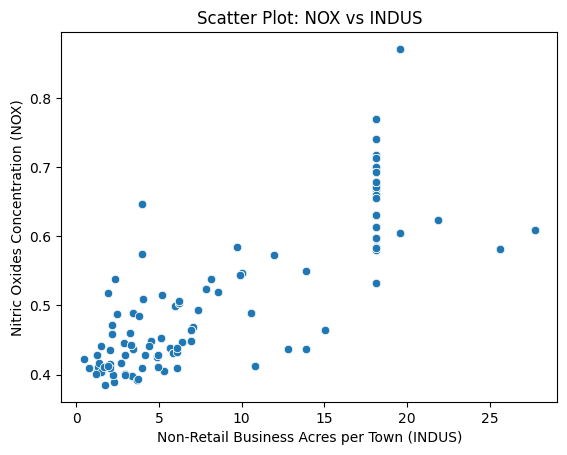

In [42]:
plot = sns.scatterplot(x="INDUS", y="NOX", data=boston_df)
plt.title('Scatter Plot: NOX vs INDUS')
plt.xlabel('Non-Retail Business Acres per Town (INDUS)')
plt.ylabel('Nitric Oxides Concentration (NOX)')
plt.show()

In [43]:
scipy.stats.pearsonr(boston_df['INDUS'], boston_df['NOX'])

PearsonRResult(statistic=0.7636514469209192, pvalue=7.913361061210442e-98)

**Conclusion:** p < 0.05 → Reject H0. Nitric oxide concentration is correlated with the proportion of non-retail business acres per town.

#### Q4. What is the impact of an additional weighted distance to the five Boston employment centres on the median value of owner occupied homes? (Regression analysis)

**State the Hypothesis:**

H0: There is no relationship between distance to employment centres (DIS) and median home value (MEDV).

H1: There is a relationship between DIS and MEDV.

In [44]:
X = boston_df[['DIS']]
y = boston_df['MEDV']
X = sm.add_constant(X)  # add intercept
X=X.astype(float)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     33.58
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.21e-08
Time:                        22:09:32   Log-Likelihood:                -1823.9
No. Observations:                 506   AIC:                             3652.
Df Residuals:                     504   BIC:                             3660.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.3901      0.817     22.499      0.000      16.784      19.996
DIS            1.0916      0.188      5.795      0.000       0.722       1.462
==============================================================================
Omnibus:                      139.779   Durbin-Watson:                   0.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.104
Skew:                           1.466   Prob(JB):                     5.59e-67
Kurtosis:                       5.424   Cond. No.                         9.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Conclusion:** p < 0.05 → Reject H0. There is a statistically significant positive relationship between distance from employment centres and median home value.

Create a **histogram** for the pupil to teacher ratio variable

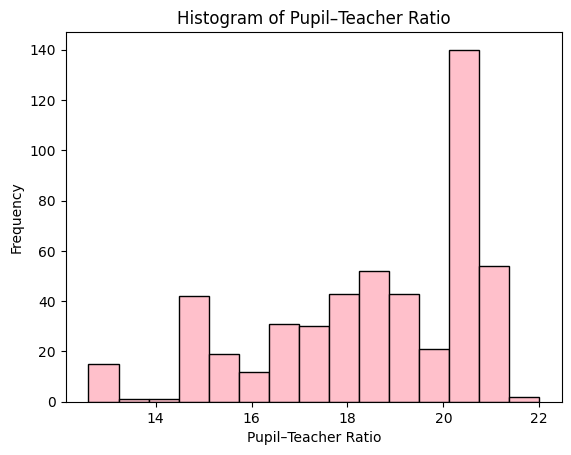

In [45]:
plt.hist(boston_df['PTRATIO'], bins=15, color='pink', edgecolor='black')
plt.xlabel('Pupil–Teacher Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Pupil–Teacher Ratio')
plt.show()